In [1]:
from smart_open import open
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Load data for attackers

In [2]:
data = pd.read_csv("../data/training_pruned_file_20162021.csv")

In [3]:
players = data.loc[lambda x: x["position"] == "Attack"]

In [4]:
sorted(players.columns.values)

['accurate_crosses.total',
 'accurate_passes.total',
 'aerials_won.total',
 'agent_name',
 'bench.total',
 'big_chances_created.total',
 'big_chances_missed.total',
 'birth.country',
 'blocked_shots.total',
 'captain.total',
 'cards.red',
 'cards.yellow',
 'cards.yellowred',
 'clearances.total',
 'common_name',
 'continent',
 'country_name',
 'date',
 'date_of_birth',
 'dispossessed.total',
 'dribbled_past.total',
 'dribbles.attempts',
 'dribbles.past',
 'dribbles.success',
 'duels.total',
 'duels.won',
 'duels_won.total',
 'error_lead_to_goal.total',
 'firstname_x',
 'foot',
 'fouls.committed',
 'fouls.drawn',
 'fouls.total',
 'fouls_drawn.total',
 'games.appearences',
 'games.captain',
 'games.lineups',
 'games.minutes',
 'games.number',
 'games.position',
 'games.rating',
 'gender',
 'global_performance',
 'goals.assists',
 'goals.conceded',
 'goals.goals',
 'goals.penalties',
 'goals.saves',
 'goals.total_y',
 'height_x',
 'highest_market_value_in_eur',
 'hit_woodwork.total',
 'int

## Select variables

In [5]:
players_selected_vars = players[[
    "name",
    "player_id_api",
    "date_of_birth",
    "nationality",
    "team_name",
    'league_name',
     'league.season',
    # "error_lead_to_goal.total",
    # "saves_inside_box.total",
    "games.appearences",
    "games.lineups",
    "games.minutes",
    # "goals.conceded",
    # "goals.saves",
    # "penalty.saved",
    # "highest_market_value_in_eur",
    "market_value_in_eur_x",
    # "own_goals.total",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]].copy().rename({
    "team_name": "team",
    "league_name": "league",
    "league.season": "season",
    "games.appearences": "matches_played",
    "games.lineups": "matches_started",
    "games.minutes": "minutes",
    # "goals.conceded": "goals_against",
    # "goals.saves": "saves",
    # "saves_inside_box.total": "saves_inside_box",
    # "penalty.saved": "penalty_kicks_saves",
    # "own_goals.total": "own_goals_against",
    # "error_lead_to_goal.total": "errors_to_goal",
    "market_value_in_eur_x": "market_value",
}, axis=1)
players_selected_vars["90s_played"] = players_selected_vars["minutes"] / 90
# players_selected_vars["goals_against_90s"] = players_selected_vars["goals_against"] / players_selected_vars["90s_played"]
# players_selected_vars["shots_on_target_against"] = players_selected_vars["goals_against"] + players_selected_vars["saves"]
# players_selected_vars["save%"] = players_selected_vars["saves"] / players_selected_vars["shots_on_target_against"]
# players_selected_vars["age"] = pd.to_datetime(players_selected_vars["date_of_birth"]).map(lambda x: int((pd.Timestamp.today() - x).days / 365))
players_selected_vars["age"] = (26 - (players["league.season"] - players["date_of_birth"].str.slice(0, 4).astype(int)))
players_selected_vars["age2"] = players_selected_vars["age"] ** 2
# players_selected_vars["own_goals_against"] = players_selected_vars["own_goals_against"].fillna(0)
for per_90 in [
    # "shots_on_target_against",
    # "saves_inside_box",
    # "saves",
    # "penalty_kicks_saves",
    # "own_goals_against",
    # "goals_against",
    # "accurate_crosses.total",
    # "big_chances_created.total",
    # "big_chances_missed.total",
    # "blocked_shots.total",
    # "dribbled_past.total",
    # "goals.goals",
    # "offsides.total",
    # "shots_off_target.total",
    # "through_balls.total",
    # "total_crosses.total",
    # "shots.total",
    # "shots.on",
    # "goals.total_y",
    # "goals.assists",
    # "passes.key",
    # "dribbles.attempts",
    # "dribbles.success",
    # "dribbles.past",
]:
    players_selected_vars[per_90] = players_selected_vars[per_90] / players_selected_vars["90s_played"]


players_selected_vars.replace([np.inf, -np.inf], np.nan, inplace=True)
    
players_selected_vars = players_selected_vars.drop([
    "date_of_birth",
    "minutes",
], axis=1)

order = [
    "name",
    "player_id_api",
    "age",
    "age2",
    "nationality",
    "league",
    "team",
    "season",
    "matches_played",
    "matches_started",
    # "minutes",
    "90s_played",
    # "goals_against",
    # "own_goals_against",
    # "shots_on_target_against",
    # "saves",
    # "save%",
    # "saves_inside_box",
    # "penalty_kicks_saves",
    "market_value",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]
players_selected_vars = players_selected_vars[order + list(set(players_selected_vars.columns).difference(order))]
players_selected_vars

,name,player_id_api,age,age2,nationality,league,team,season,matches_played,matches_started,...,through_balls.total,total_crosses.total,shots.total,shots.on,goals.total_y,goals.assists,passes.key,dribbles.attempts,dribbles.success,dribbles.past
0,George Thomas,20479,6,36,Wales,Premier League,Leicester City,2017,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,Kelechi Promise Iheanacho,2778,5,25,Nigeria,Premier League,Leicester City,2017,21.0,7.0,...,NaN,5.0,29.0,11.0,3.0,3.0,11.0,18.0,13.0,NaN
6,Demarai Gray,18781,5,25,England,Premier League,Leicester City,2017,35.0,17.0,...,NaN,86.0,36.0,9.0,3.0,1.0,29.0,63.0,38.0,NaN
7,Riyad Mahrez,635,0,0,Algeria,Premier League,Leicester City,2017,36.0,34.0,...,NaN,157.0,73.0,36.0,12.0,10.0,59.0,157.0,80.0,NaN
9,Shinji Okazaki,18787,-5,25,Japan,Premier League,Leicester City,2017,27.0,17.0,...,NaN,6.0,28.0,16.0,6.0,2.0,15.0,38.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14762,Johann Berg Guðmunds­son,2790,-5,25,Iceland,Premier League,Burnley,2021,18.0,13.0,...,NaN,44.0,12.0,5.0,0.0,1.0,7.0,22.0,14.0,NaN
14765,Dwight McNeil,18929,4,16,England,Premier League,Burnley,2021,38.0,35.0,...,NaN,199.0,32.0,15.0,0.0,1.0,49.0,150.0,90.0,NaN
14768,Matěj Vydra,18930,-3,9,Czech Republic,Premier League,Burnley,2021,22.0,5.0,...,NaN,2.0,15.0,7.0,2.0,3.0,6.0,14.0,6.0,NaN
14770,Ashley Barnes,18927,-6,36,England,Premier League,Burnley,2021,23.0,8.0,...,NaN,2.0,14.0,6.0,1.0,NaN,8.0,8.0,5.0,NaN


<Axes: xlabel='age'>

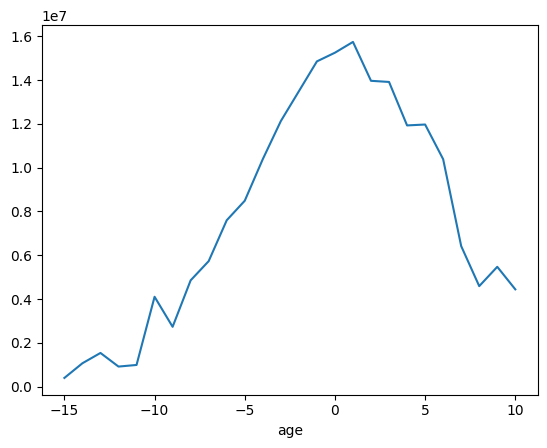

In [6]:
players_selected_vars.groupby("age")["market_value"].mean().plot()

In [7]:
from helpers import TEAM_TIERS

In [8]:
players_selected_vars = pd.merge(players_selected_vars, TEAM_TIERS, left_on="team", right_index=True)

In [9]:
mvs = players_selected_vars["market_value"].values
mvs = np.expand_dims(mvs, axis=1)
mvs = normalize(mvs, norm="max", axis=0)
mvs = np.squeeze(mvs)
players_selected_vars["normalised_market_value"] = mvs

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [11]:
market_values = players_selected_vars[["player_id_api", "season", "market_value"]]
market_values["season"] = market_values["season"] +1
market_values

/var/folders/h8/j63w626x3ds50k3yc8j6xtwh0000gn/T/ipykernel_88374/2427455660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_values["season"] = market_values["season"] +1


,player_id_api,season,market_value
0,20479,2018,500000
4,2778,2018,15000000
6,18781,2018,20000000
7,635,2018,50000000
9,18787,2018,6000000
...,...,...,...
14667,128533,2022,4500000
14668,194682,2022,800000
14669,48563,2022,1000000
14681,1827,2022,2000000


In [12]:
players_selected_vars = pd.merge(players_selected_vars, market_values, on=["player_id_api", "season"], suffixes = ["", "_prev"])

## Transformation pipeline

In [13]:
numeric_features = [
    "market_value_prev",
    "age",
    "age2",
    "matches_played",
    "matches_started",
    "90s_played",
    # "goals_against",
    # "own_goals_against",
    # "shots_on_target_against",
    # "saves",
    # "save%",
    # "saves_inside_box",
    # "penalty_kicks_saves",
    "accurate_crosses.total",
    "big_chances_created.total",
    "big_chances_missed.total",
    "blocked_shots.total",
    "dribbled_past.total",
    "goals.goals",
    "offsides.total",
    "shots_off_target.total",
    "through_balls.total",
    "total_crosses.total",
    "shots.total",
    "shots.on",
    "goals.total_y",
    "goals.assists",
    "passes.key",
    "dribbles.attempts",
    "dribbles.success",
    "dribbles.past",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features = [
    "nationality",
    "league",
    "team",
    "tier",
]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Predict price bucket

In [14]:
bins = [
    0.0025,
    0.005,
    0.01,
    0.025,
    0.05,
    0.1,
    0.25,
    0.5,
    1.0
]
y = np.digitize(players_selected_vars["normalised_market_value"], bins)
X = players_selected_vars

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
np.unique(y_train, return_counts=True)

In [ ]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

y_random = random.predict(X_test)

balanced_accuracy_score(y_test, y_random)

In [ ]:
np.unique(y_random, return_counts=True)

In [ ]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

y_lr = clf.predict(X_test)

balanced_accuracy_score(y_test, y_lr)

In [ ]:
np.unique(y_test - y_lr, return_counts=True)

In [ ]:
np.unique(y_lr, return_counts=True)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 8, 4))),
    ]
)
mlp.fit(X_train, y_train)

y_mlp = mlp.predict(X_test)

balanced_accuracy_score(y_test, y_mlp)

## Features importance

In [ ]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict market value

In [15]:
def r2_adj(model, x,y):
    r2 = model.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

In [16]:
players_selected_vars.query("player_id_api == 18788")

,name,player_id_api,age,age2,nationality,league,team,season,matches_played,matches_started,...,shots.on,goals.total_y,goals.assists,passes.key,dribbles.attempts,dribbles.success,dribbles.past,tier,normalised_market_value,market_value_prev
4,Jamie Vardy,18788,-5,25,England,Premier League,Leicester City,2018,34.0,30.0,...,40.0,18.0,4.0,32.0,33.0,12.0,NaN,3,0.100,20000000
7,Jamie Vardy,18788,-6,36,England,Premier League,Leicester City,2019,35.0,34.0,...,43.0,23.0,5.0,32.0,47.0,23.0,NaN,3,0.080,20000000
13,Jamie Vardy,18788,-7,49,England,Premier League,Leicester City,2020,34.0,31.0,...,38.0,15.0,9.0,28.0,41.0,26.0,NaN,3,0.035,16000000
24,Jamie Vardy,18788,-8,64,England,Premier League,Leicester City,2021,25.0,20.0,...,26.0,15.0,2.0,18.0,22.0,9.0,NaN,3,0.025,7000000


In [17]:
appearances = 15
X = players_selected_vars.loc[lambda x: np.logical_and(x["matches_played"] >= appearances, x["market_value"] != x["market_value_prev"])]
# y = players_selected_vars["normalised_market_value"]
y = np.log(players_selected_vars.loc[lambda x: np.logical_and(x["matches_played"] >= appearances, x["market_value"] != x["market_value_prev"])]["market_value"])
# y = players_selected_vars["market_value"]

In [18]:
X_train = X.loc[X["season"] <= 2020]
X_test = X.loc[X["season"] == 2021]
y_train = y.loc[X["season"] <= 2020]
y_test = y.loc[X["season"] == 2021]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1327, 33), (441, 33), (1327,), (441,))

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
random_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regression", DummyRegressor()),
    ]
)
random_regression.fit(X_train, y_train)

random_regression.score(X_test, y_test), r2_adj(random_regression, X_test, y_test)

(-0.008264759541563249, -0.09001595626114955)

In [21]:
regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regression", LinearRegression()),
    ]
)
regression.fit(X_train, y_train)

regression.score(X_train, y_train), r2_adj(regression, X_train, y_train), regression.score(X_test, y_test), r2_adj(regression, X_test, y_test)

(0.8847971464303185, 0.881856934390257, 0.8296910748854155, 0.8158822431193681)

In [22]:
from sklearn.neural_network import MLPRegressor

mlp_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regression", MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 2))),
    ]
)
mlp_reg.fit(X_train, y_train)

mlp_reg.score(X_train, y_train), r2_adj(mlp_reg, X_train, y_train), mlp_reg.score(X_test, y_test), r2_adj(mlp_reg, X_test, y_test)

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(0.9532843853766484, 0.952092107509231, 0.6930905455961442, 0.6682059952390749)

In [23]:
from xgboost import XGBRegressor

xgboost_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regression", XGBRegressor(n_estimators=500, max_depth=3, reg_lambda=50)),
    ]
)
xgboost_reg.fit(X_train, y_train)

xgboost_reg.score(X_train, y_train), r2_adj(xgboost_reg, X_train, y_train), xgboost_reg.score(X_test, y_test), r2_adj(xgboost_reg, X_test, y_test)

(0.987395658249111, 0.9870739697125455, 0.9145755123705782, 0.9076492025627872)

In [24]:
###### from xgboost import XGBRegressor

xgboost_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regression", XGBRegressor(n_estimators=500, max_depth=3, reg_lambda=50)),
    ]
)
xgboost_reg.fit(X_train, y_train)

print(xgboost_reg.score(X_train, y_train), r2_adj(xgboost_reg, X_train, y_train), xgboost_reg.score(X_test, y_test), r2_adj(xgboost_reg, X_test, y_test))

0.987395658249111 0.9870739697125455 0.9145755123705782 0.9076492025627872


In [25]:
reg_results = pd.DataFrame({
    "y": np.exp(y_test),
    "y_pred": np.exp(xgboost_reg.predict(X_test))
    # "y_pred": np.exp(regression.predict(X_test))
    # "y": y_test,
    # "y_pred": xgboost_reg.predict(X_test)
})
reg_results["diff"] = reg_results["y_pred"] - reg_results["y"]
reg_results["rel_error"] = reg_results["diff"] / reg_results["y"] * 100
reg_results["abs_rel_error"] = np.abs(reg_results["rel_error"])
reg_results = reg_results.sort_values("abs_rel_error")
reg_results

,y,y_pred,diff,rel_error,abs_rel_error
2234,40000000.0,3.995588e+07,-4.412000e+04,-0.110300,0.110300
2080,16000000.0,1.596207e+07,-3.793100e+04,-0.237069,0.237069
389,18000000.0,1.794222e+07,-5.777800e+04,-0.320989,0.320989
2510,12000000.0,1.195572e+07,-4.427900e+04,-0.368992,0.368992
108,12000000.0,1.195326e+07,-4.674100e+04,-0.389508,0.389508
...,...,...,...,...,...
2815,400000.0,9.534909e+05,5.534909e+05,138.372734,138.372734
2314,12000000.0,2.927793e+07,1.727793e+07,143.982783,143.982783
1259,2500000.0,6.505032e+06,4.005031e+06,160.201260,160.201260
1258,2500000.0,6.505032e+06,4.005031e+06,160.201260,160.201260


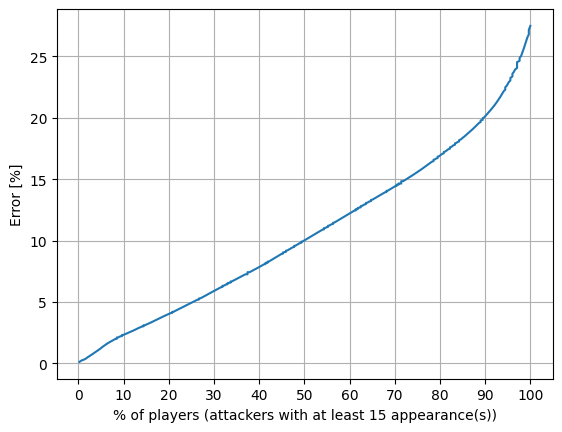

In [26]:
plt.plot(
    reg_results["abs_rel_error"].rank() / len(reg_results["abs_rel_error"]) * 100,
    reg_results["abs_rel_error"].cumsum() / reg_results["abs_rel_error"].rank()
)
plt.xticks(np.linspace(0, 1, 11)*100)
plt.xlabel(f"% of players (attackers with at least {appearances} appearance(s))")
plt.ylabel("Error [%]")
plt.grid()
plt.show()

In [27]:
np.floor(reg_results["abs_rel_error"])

2234      0.0
2080      0.0
389       0.0
2510      0.0
108       0.0
        ...  
2815    138.0
2314    143.0
1259    160.0
1258    160.0
2551    181.0
Name: abs_rel_error, Length: 441, dtype: float64

In [28]:
_x, _y = np.unique(np.floor(reg_results["abs_rel_error"]), return_counts=True)

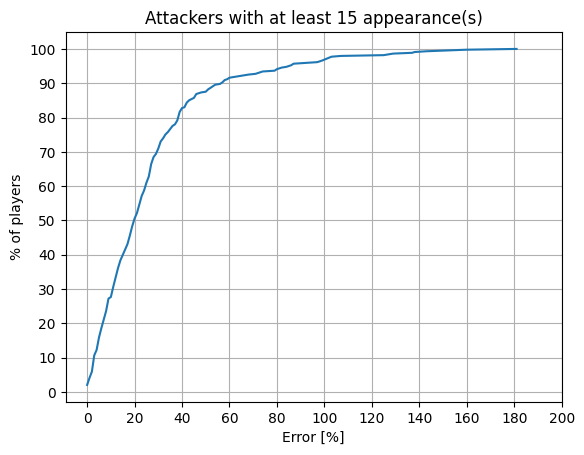

In [29]:
plt.plot(
    _x,
    _y.cumsum() / len(reg_results) * 100
)
plt.grid()
plt.xlabel("Error [%]")
plt.ylabel(f"% of players")
plt.title(f"Attackers with at least {appearances} appearance(s)")
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.arange(0, 201, 20))
plt.show()


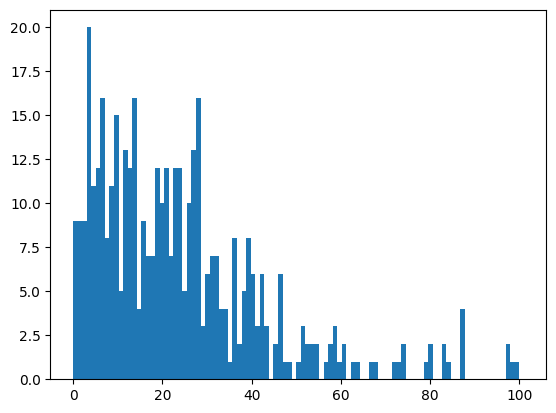

In [30]:
_ = plt.hist(reg_results["abs_rel_error"], bins=list(np.linspace(0, 101, 100)))

In [31]:
# pd.merge(X_test.join(reg_results), X_train[["player_id_api", "age", "market_value", "season"]], on="player_id_api")

In [32]:
# _ = plt.hist(reg_results["abs_rel_error"], bins=100)

In [33]:
np.mean(reg_results["abs_rel_error"]), np.median(reg_results["abs_rel_error"])

(27.48573983206832, 20.88705600000012)

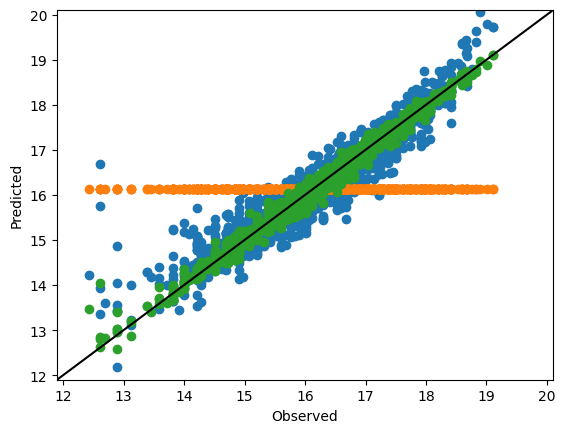

In [34]:
plt.scatter(y_train, regression.predict(X_train))
plt.scatter(y_train, random_regression.predict(X_train))
plt.scatter(y_train, xgboost_reg.predict(X_train))
# plt.scatter(y_train, mlp_reg.predict(X_train))
plt.axline((0, 0), (1, 1), c="k")
plt.xlim(np.floor(y_train.min())-0.1, np.ceil(y_train.max())+0.1)
plt.ylim(np.floor(y_train.min())-0.1, np.ceil(y_train.max())+0.1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
_ = plt.show()

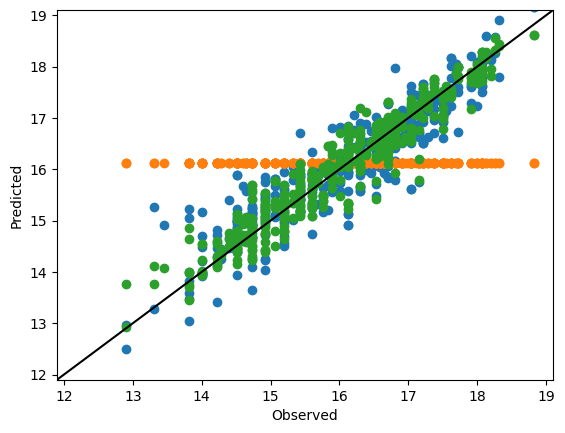

In [35]:
plt.scatter(y_test, regression.predict(X_test))
plt.scatter(y_test, random_regression.predict(X_test))
plt.scatter(y_test, xgboost_reg.predict(X_test))
plt.axline((0, 0), (1, 1), c="k")
plt.xlim(np.floor(y_test.min())-0.1, np.ceil(y_test.max())+0.1)
plt.ylim(np.floor(y_test.min())-0.1, np.ceil(y_test.max())+0.1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
_ = plt.show()

## Features importance

In [ ]:
result = permutation_importance(
    xgboost_reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict change in market value between seasons

In [ ]:
before_after_seasons = pd.merge(
    players_selected_vars, 
    players_selected_vars, 
    on="player_id_api", 
    suffixes=["_before", "_after"]
).query("season_after - season_before == 1")

In [ ]:
numeric_features_ba = [
    f"{c}_{suffix}" for c in [
        "age",
        "matches_played",
        "matches_started",
        "90s_played",
        # "goals_against",
        # "own_goals_against",
        # "shots_on_target_against",
        # "saves",
        # "save%",
        # "saves_inside_box",
        # "penalty_kicks_saves",
        "accurate_crosses.total",
        "big_chances_created.total",
        "big_chances_missed.total",
        "blocked_shots.total",
        "dribbled_past.total",
        "goals.goals",
        "offsides.total",
        "shots_off_target.total",
        "through_balls.total",
        "total_crosses.total",
        "shots.total",
        "shots.on",
        "goals.total_y",
        "goals.assists",
        "passes.key",
        "dribbles.attempts",
        "dribbles.success",
        "dribbles.past",
    ]
    for suffix in ["before","after"]
]
numeric_transformer_ba = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features_ba = [
    f"{c}_{suffix}" for c in [
        "nationality",
        "league",
        "team",
        "tier",
    ]
    for suffix in ["before","after"]
]
categorical_transformer_ba = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_ba = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ba, numeric_features_ba),
        ("cat", categorical_transformer_ba, categorical_features_ba),
    ]
)

In [ ]:
X = before_after_seasons
y_before = np.digitize(before_after_seasons["normalised_market_value_before"], bins)
y_after = np.digitize(before_after_seasons["normalised_market_value_after"], bins)
y = np.minimum(np.maximum(y_after - y_before, -1), 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

balanced_accuracy_score(y_test, random.predict(X_test))

In [ ]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test), labels=[1, 0, -1]))

balanced_accuracy_score(y_test, clf.predict(X_test))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16))),
    ]
)
mlp.fit(X_train, y_train)

print(confusion_matrix(y_test, mlp.predict(X_test), labels=[1, 0, -1]))

balanced_accuracy_score(y_test, mlp.predict(X_test))

In [ ]:
from xgboost import XGBClassifier

xgboost = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", XGBClassifier()),
    ]
)
xgboost.fit(X_train, y_train+1)

y_xgboost = xgboost.predict(X_test)

balanced_accuracy_score(y_test+1, y_xgboost)

## Features importance

In [ ]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()